Matteo Picciolini

# Esercitazione 10

In [1]:
#matplotlib
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D

#numpy
import numpy as np

#center graphs
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

### Exercise 10.1

Choose **ONLY ONE** of the two following possibilities:

1. Parallelize with MPI libraries your Genetic Algorithm code in order to solve the TSP by performing a *Genetic Search* with (up to) 10 **parallel GA searches of the optimal path**:
each node should perform an independent GA search, the so-called *Continent*, **but** every $N_{migr}$ generations the *Continents* should exchange their best individuals randomly.

2. Starting from your Genetic Algorithm code implement a **Parallel Tempering algorithm** (Simulated Annealing with many temperatures). Parallelize with MPI libraries your algorithm in order to solve the TSP where each computing node, up to 10, is characterized by a different temperature or a limited set of temperatures (if you need more than 10 temperatures). Use your genetic operators (except crossover) as trial moves for the Metropolis algorithm and **add a trial move that proposes an exchange of paths among adjacent temperatures (nodes)** (see lecture 8 for the acceptance formula). The candidate solution of the TSP will appear on the node with the lower temperature.

### Exercise 10.2

Apply your parallel code to the TSP problem for 50 american state-capitals longitude and latitude coordinates in the *American_capitals.dat* file.

If your choice in Exercise 10.1 is option 1, do you improve with respect using the same number of computing cores but with **independent GA searches** ?

If your choice in Exercise 10.1 is option 2, by using a number of temperatures equal to the number of individuals in your **non-parallel Genetic Algorithm code**, do you "improve" with respect to it?

### Risoluzione

<img src="../Data/10.1_core_animation.gif"/>

#### Continenti indipendenti


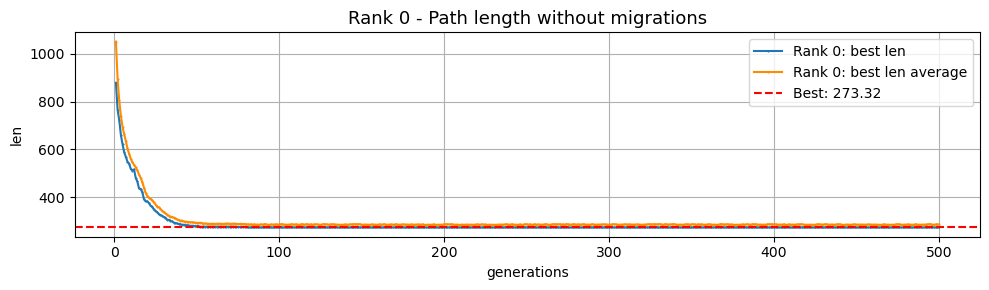

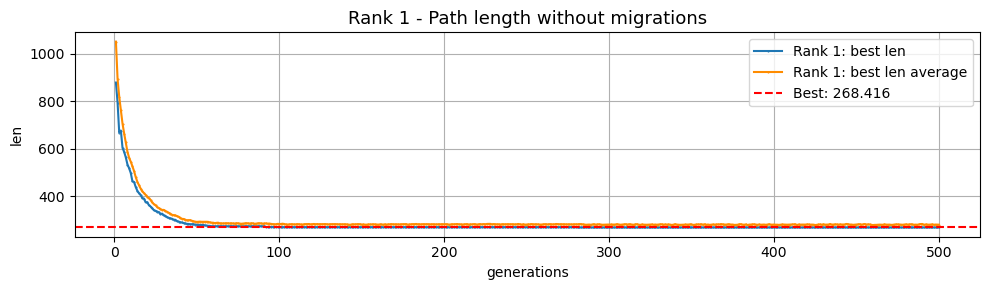

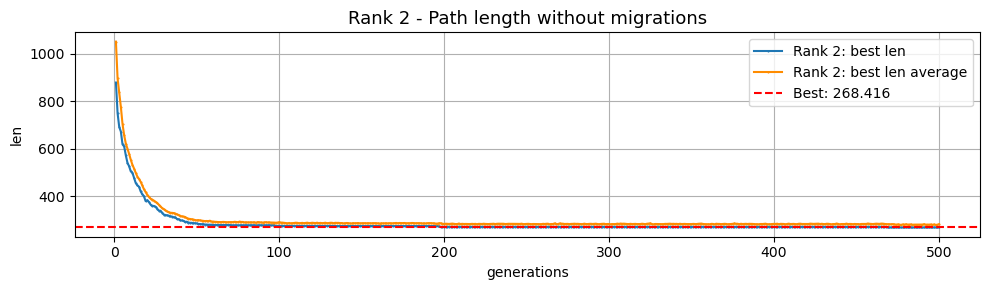

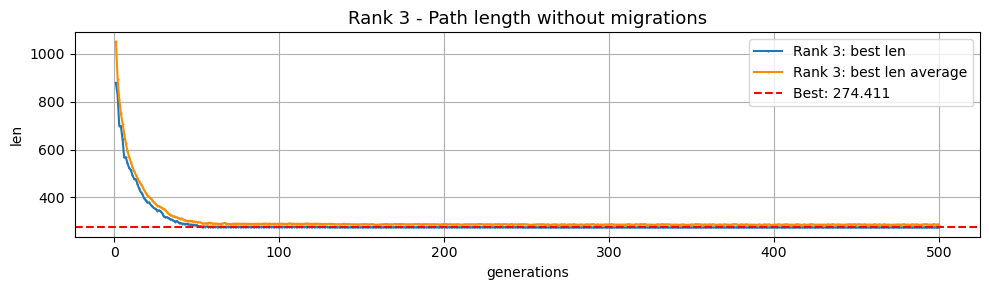

In [2]:
plt.figure(figsize = (10,3))
x_best_len, y_best_len = np.loadtxt('../Data/10.1_false_0_best_len.dat', unpack = True, usecols = (0, 1)) 
plt.plot(x_best_len, y_best_len, marker = 'o', 
             markersize = 0.5, label = 'Rank 0: best len')
x_best_len_ave, y_best_len_ave = np.loadtxt('../Data/10.1_false_0_best_len_average.dat', unpack = True, usecols = (0, 1)) 
plt.plot(x_best_len_ave, y_best_len_ave, marker = 'o', 
             markersize = 0.5, label = 'Rank 0: best len average', color = 'darkorange')
plt.axhline(y=y_best_len[499], color = "red",  linestyle = "--", label = "Best: "+str(y_best_len[499]))
plt.title('Rank 0 - Path length without migrations', fontsize = 13)
plt.ylabel('len')
plt.xlabel('generations')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

plt.figure(figsize = (10,3))
x_best_len, y_best_len = np.loadtxt('../Data/10.1_false_1_best_len.dat', unpack = True, usecols = (0, 1)) 
plt.plot(x_best_len, y_best_len, marker = 'o', 
             markersize = 0.5, label = 'Rank 1: best len')
x_best_len_ave, y_best_len_ave = np.loadtxt('../Data/10.1_false_1_best_len_average.dat', unpack = True, usecols = (0, 1)) 
plt.plot(x_best_len_ave, y_best_len_ave, marker = 'o', 
             markersize = 0.5, label = 'Rank 1: best len average', color = 'darkorange')
plt.axhline(y=y_best_len[499], color = "red", linestyle = "--", label = "Best: "+str(y_best_len[499]))
plt.title('Rank 1 - Path length without migrations', fontsize = 13)
plt.ylabel('len')
plt.xlabel('generations')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


plt.figure(figsize = (10,3))
x_best_len, y_best_len = np.loadtxt('../Data/10.1_false_2_best_len.dat', unpack = True, usecols = (0, 1)) 
plt.plot(x_best_len, y_best_len, marker = 'o', 
             markersize = 0.5, label = 'Rank 2: best len')
x_best_len_ave, y_best_len_ave = np.loadtxt('../Data/10.1_false_2_best_len_average.dat', unpack = True, usecols = (0, 1)) 
plt.plot(x_best_len_ave, y_best_len_ave, marker = 'o', 
             markersize = 0.5, label = 'Rank 2: best len average', color = 'darkorange')
plt.axhline(y=y_best_len[499], color = "red", linestyle = "--", label = "Best: "+str(y_best_len[499]))
plt.title('Rank 2 - Path length without migrations', fontsize = 13)
plt.ylabel('len')
plt.xlabel('generations')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

plt.figure(figsize = (10,3))
x_best_len, y_best_len = np.loadtxt('../Data/10.1_false_3_best_len.dat', unpack = True, usecols = (0, 1)) 
plt.plot(x_best_len, y_best_len, marker = 'o', 
             markersize = 0.5, label = 'Rank 3: best len')
x_best_len_ave, y_best_len_ave = np.loadtxt('../Data/10.1_false_3_best_len_average.dat', unpack = True, usecols = (0, 1)) 
plt.plot(x_best_len_ave, y_best_len_ave, marker = 'o', 
             markersize = 0.5, label = 'Rank 3: best len average', color = 'darkorange')
plt.axhline(y=y_best_len[499], color = "red", linestyle = "--", label = "Best: "+str(y_best_len[499]))
plt.title('Rank 3 - Path length without migrations', fontsize = 13)
plt.ylabel('len')
plt.xlabel('generations')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

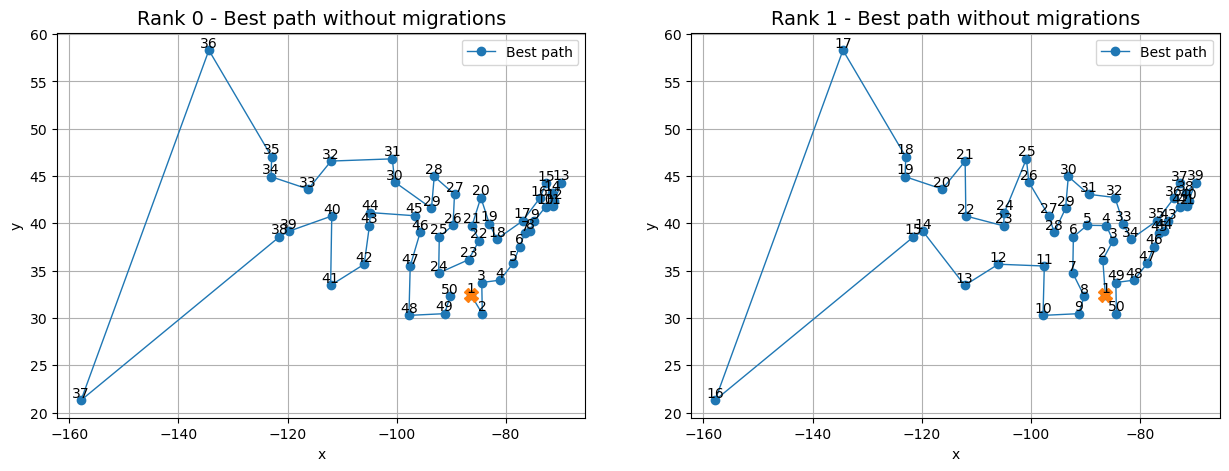

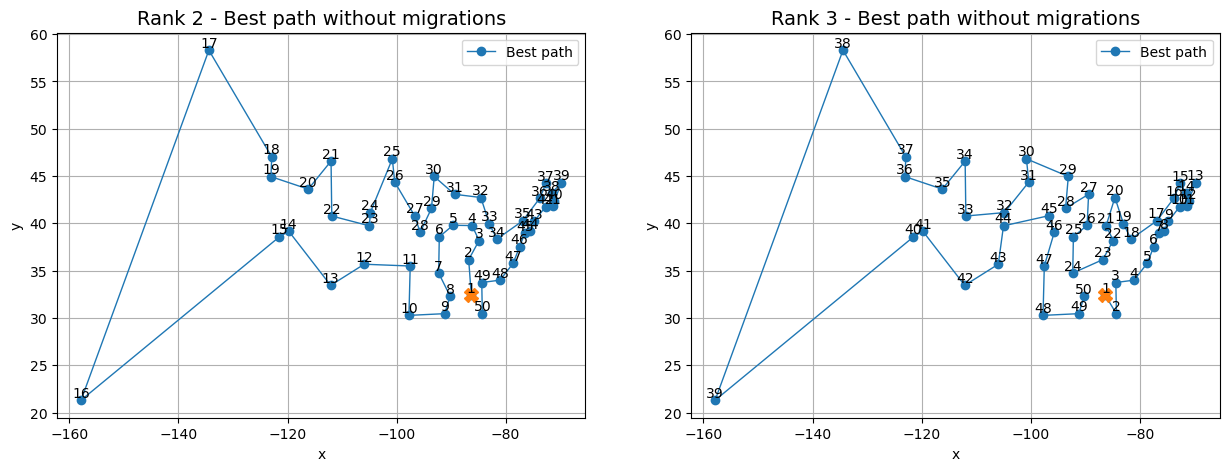

In [3]:
# FIRST ROW

fig, axs = plt.subplots(1, 2, figsize = (15, 5))
x, y = np.loadtxt("../Data/10.1_city_coord_false_0_500.dat", usecols = (0, 1), delimiter = ' ', unpack = True)
axs[0].plot(x, y, marker = "o", linestyle = '-', lw = 1,  label = 'Best path')
for i in range(len(x)):
    axs[0].text(x[i], y[i], str(i + 1), ha = 'center', va = 'bottom')
axs[0].plot(x[0], y[0], marker = "X", markersize = 10)
axs[0].set_ylabel('y')
axs[0].set_xlabel('x')
axs[0].grid(True)
axs[0].set_title('Rank 0 - Best path without migrations', fontsize = 14)
axs[0].legend();


x, y = np.loadtxt("../Data/10.1_city_coord_false_1_500.dat", usecols = (0, 1), delimiter = ' ', unpack = True)
plt.plot(x, y, marker = "o", lw = "1", linestyle = '-', label = 'Best path')
for i in range(len(x)):
    axs[1].text(x[i], y[i], str(i + 1), ha = 'center', va = 'bottom')
axs[1].plot(x[0], y[0], marker = "X", markersize = 10)
axs[1].set_ylabel('y')
axs[1].set_xlabel('x')
axs[1].grid(True)
axs[1].set_title("Rank 1 - Best path without migrations", fontsize = 14)
axs[1].legend(loc = "upper right");
plt.show()


#SECOND ROW
fig, axs = plt.subplots(1, 2, figsize = (15, 5))
x, y = np.loadtxt("../Data/10.1_city_coord_false_2_500.dat", usecols = (0, 1), delimiter = ' ', unpack = True)
axs[0].plot(x, y, marker = "o", linestyle = '-', lw = 1,  label = 'Best path')
for i in range(len(x)):
    axs[0].text(x[i], y[i], str(i + 1), ha = 'center', va = 'bottom')
axs[0].plot(x[0], y[0], marker = "X", markersize = 10)
axs[0].set_ylabel('y')
axs[0].set_xlabel('x')
axs[0].grid(True)
axs[0].set_title('Rank 2 - Best path without migrations', fontsize = 14)
axs[0].legend();


x, y = np.loadtxt("../Data/10.1_city_coord_false_3_500.dat", usecols = (0, 1), delimiter = ' ', unpack = True)
plt.plot(x, y, marker = "o", lw = "1", linestyle = '-', label = 'Best path')
for i in range(len(x)):
    axs[1].text(x[i], y[i], str(i + 1), ha = 'center', va = 'bottom')
axs[1].plot(x[0], y[0], marker = "X", markersize = 10)
axs[1].set_ylabel('y')
axs[1].set_xlabel('x')
axs[1].grid(True)
axs[1].set_title("Rank 3 - Best path without migrations", fontsize = 14)
axs[1].legend(loc = "upper right");
plt.show()

<img src="../Data/10.1_false_animation.gif"/>

#### Migrazioni

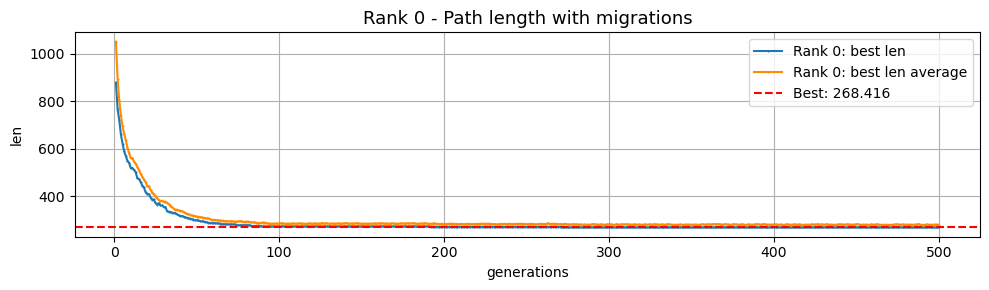

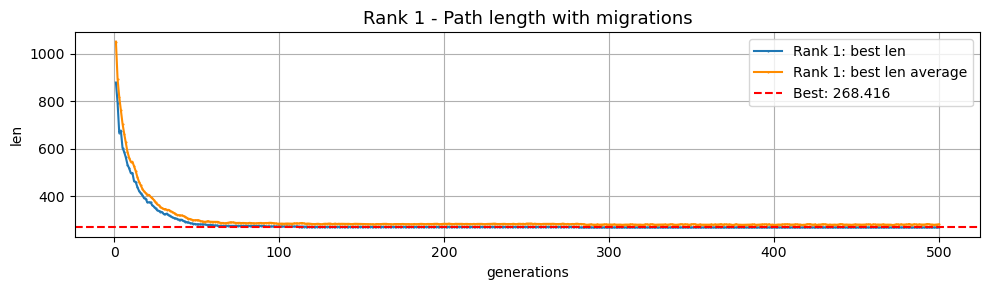

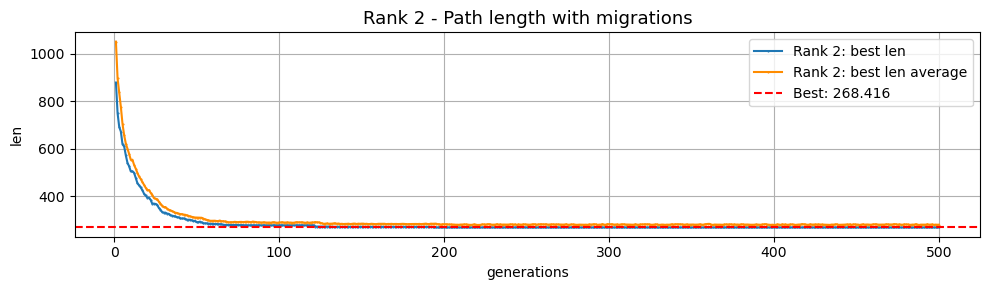

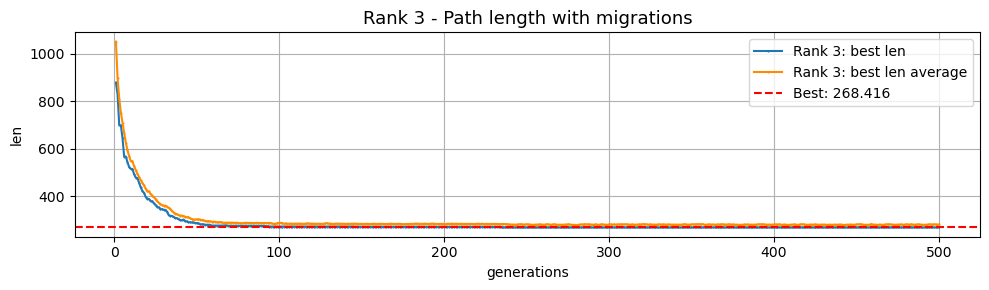

In [4]:
plt.figure(figsize = (10,3))
x_best_len, y_best_len = np.loadtxt('../Data/10.1_true_0_best_len.dat', unpack = True, usecols = (0, 1)) 
plt.plot(x_best_len, y_best_len, marker = 'o', 
             markersize = 0.5, label = 'Rank 0: best len')
x_best_len_ave, y_best_len_ave = np.loadtxt('../Data/10.1_true_0_best_len_average.dat', unpack = True, usecols = (0, 1)) 
plt.plot(x_best_len_ave, y_best_len_ave, marker = 'o', 
             markersize = 0.5, label = 'Rank 0: best len average', color = 'darkorange')
plt.axhline(y=y_best_len[499], color = "red",  linestyle = "--", label = "Best: "+str(y_best_len[499]))
plt.title('Rank 0 - Path length with migrations', fontsize = 13)
plt.ylabel('len')
plt.xlabel('generations')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

plt.figure(figsize = (10,3))
x_best_len, y_best_len = np.loadtxt('../Data/10.1_true_1_best_len.dat', unpack = True, usecols = (0, 1)) 
plt.plot(x_best_len, y_best_len, marker = 'o', 
             markersize = 0.5, label = 'Rank 1: best len')
x_best_len_ave, y_best_len_ave = np.loadtxt('../Data/10.1_true_1_best_len_average.dat', unpack = True, usecols = (0, 1)) 
plt.plot(x_best_len_ave, y_best_len_ave, marker = 'o', 
             markersize = 0.5, label = 'Rank 1: best len average', color = 'darkorange')
plt.axhline(y=y_best_len[499], color = "red", linestyle = "--", label = "Best: "+str(y_best_len[499]))
plt.title('Rank 1 - Path length with migrations', fontsize = 13)
plt.ylabel('len')
plt.xlabel('generations')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


plt.figure(figsize = (10,3))
x_best_len, y_best_len = np.loadtxt('../Data/10.1_true_2_best_len.dat', unpack = True, usecols = (0, 1)) 
plt.plot(x_best_len, y_best_len, marker = 'o', 
             markersize = 0.5, label = 'Rank 2: best len')
x_best_len_ave, y_best_len_ave = np.loadtxt('../Data/10.1_true_2_best_len_average.dat', unpack = True, usecols = (0, 1)) 
plt.plot(x_best_len_ave, y_best_len_ave, marker = 'o', 
             markersize = 0.5, label = 'Rank 2: best len average', color = 'darkorange')
plt.axhline(y=y_best_len[499], color = "red", linestyle = "--", label = "Best: "+str(y_best_len[499]))
plt.title('Rank 2 - Path length with migrations', fontsize = 13)
plt.ylabel('len')
plt.xlabel('generations')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

plt.figure(figsize = (10,3))
x_best_len, y_best_len = np.loadtxt('../Data/10.1_true_3_best_len.dat', unpack = True, usecols = (0, 1)) 
plt.plot(x_best_len, y_best_len, marker = 'o', 
             markersize = 0.5, label = 'Rank 3: best len')
x_best_len_ave, y_best_len_ave = np.loadtxt('../Data/10.1_true_3_best_len_average.dat', unpack = True, usecols = (0, 1)) 
plt.plot(x_best_len_ave, y_best_len_ave, marker = 'o', 
             markersize = 0.5, label = 'Rank 3: best len average', color = 'darkorange')
plt.axhline(y=y_best_len[499], color = "red", linestyle = "--", label = "Best: " + str(y_best_len[499]))
plt.title('Rank 3 - Path length with migrations', fontsize = 13)
plt.ylabel('len')
plt.xlabel('generations')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

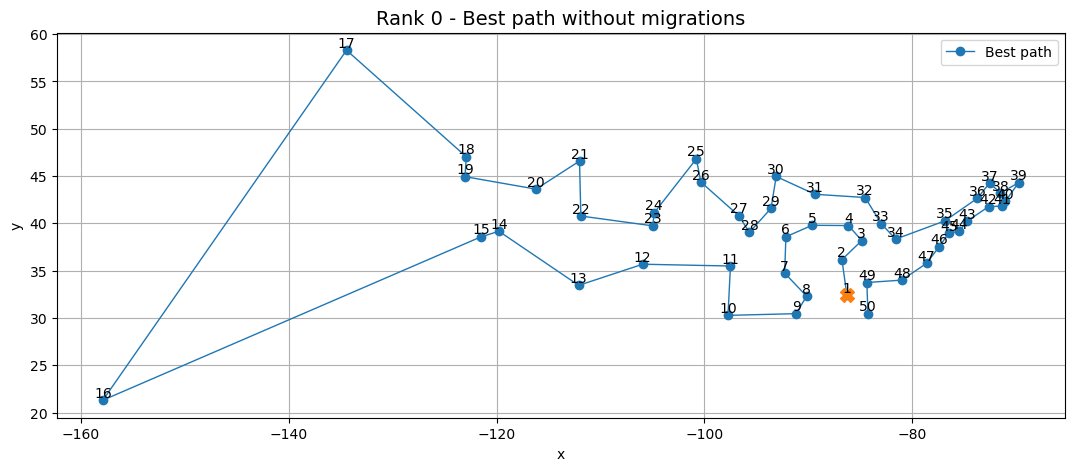

In [5]:
# FIRST ROW

fig, ax = plt.subplots(figsize = (13, 5))
x, y = np.loadtxt("../Data/10.1_city_coord_true_0_500.dat", usecols = (0, 1), delimiter = ' ', unpack = True)
ax.plot(x, y, marker = "o", linestyle = '-', lw = 1,  label = 'Best path')
for i in range(len(x)):
    ax.text(x[i], y[i], str(i + 1), ha = 'center', va = 'bottom')
ax.plot(x[0], y[0], marker = "X", markersize = 10)
ax.set_ylabel('y')
ax.set_xlabel('x')
ax.grid(True)
ax.set_title('Rank 0 - Best path without migrations', fontsize = 14)
ax.legend();
plt.show()

<img src="../Data/10.1_true_animation.gif"/>